# Plotting figures of the article
You might want to consider running the simulations on multiple cores or on a cluster before executing this notebook, using the CogSci-Running notebook. This notebook works in the same way for parameter definitions, and plots the monitored functions.

In [1]:
import naminggamesal as ngal
import matplotlib.pyplot as plt

In [2]:
def xp_cfg(N,M,W,time_scale=0,accpol=False,gamma=0.1):
    base_cfg = {
          "step": "log_improved", 
          "pop_cfg": {
            "voc_cfg": {
          "voc_type": 'matrix_new'
            }, 
        "strat_cfg": {
          "vu_cfg": {
            "vu_type": "minimal"
          }, 
          "success_cfg": {
            "success_type": "global_norandom"
              }, 
              "strat_type": "naive"
            }, 
            "nbagent": N, 
            "env_cfg": {
              "env_type": "simple", 
              "M": M, 
              "W": W
            }, 
            "interact_cfg": {
              "interact_type": "speakerschoice"
            }
          }
        }
    if accpol:
        base_cfg['pop_cfg']['strat_cfg'].update(**{
                'strat_type':'lapsmax_mab_explothreshold','bandit_type':'bandit_laps','gamma':gamma,'time_scale':time_scale,
                "memory_policies": [{
                      "time_scale": time_scale, 
                      "mem_type": "interaction_counts_sliding_window_local"
                        }], })
    return base_cfg

In [3]:

import matplotlib

fontsize = 15
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rcParams['xtick.labelsize'] = fontsize
matplotlib.rcParams['ytick.labelsize'] = fontsize
matplotlib.rcParams['axes.titlesize'] = fontsize+5
matplotlib.rcParams['axes.labelsize'] = fontsize
matplotlib.rcParams['legend.fontsize'] = fontsize
matplotlib.rcParams['figure.figsize'] = 8,5.5
matplotlib.rcParams['lines.linewidth'] = 3

testcases = [
    {'N':40,'M':40,'W':40,'Tmax':10*10**4,'gamma':0.01},  #N: population size, M:number of meanings
    {'N':40,'M':40,'W':40,'Tmax':10*10**4,'gamma':1.}     #W: number of words, Tmax: #interactions per run
]

timesc_values = [0,1,2,3,4,5,6,7,8,9,10,20,30,50,70,100] #values for the timescale parameter
tsc_2 = [1,2,10,30,50] #use only few values for the last graphs

analysis_f = [  #analysis functions
    'srtheo',     # probability of success
    'Nlink',      # vocabulary size (agent level): local complexity
    'N_d',        # vocabulary size (population level): global complexity
    'homonymy',   # average degree of homonymy 
    'synonymy',   # average degree of synonymy
    'N_meanings', # average number of meanings known by each agent
    'N_words'     # average number of words known by each agent
]

an_f_glob = [#analysis functions at the experiment level
    'conv_time',  # convergence time
    'max_mem',    # average maximum voc size per agent (max Nlink)
    'max_N_d']    # average maximum size of global voc (max N_d)

nb_iter = 8 # results averaged over nb_iter trials per configuration


nb_iter = 8

In [4]:
db = ngal.ngdb.NamingGamesDB()

In [5]:
def run_testcase(N,M,W,Tmax,nbiter=1,gamma=0.1):
    cfg_l = [xp_cfg(N,M,W)]+[xp_cfg(N,M,W,accpol=True,time_scale=t,gamma=gamma) for t in timesc_values]
    for cfg in cfg_l:
        blacklist = []
        for i in range(nbiter):
            xp = db.get_experiment(blacklist=blacklist,**cfg)
            xp.continue_exp_until(Tmax)
            blacklist.append(xp.uuid)

In [6]:
def get_merged_graph(cfg,an_f,nbiter=1):
    blacklist = []
    xp_l = []
    for i in range(nbiter):
        xp = db.get_experiment(blacklist=blacklist,**cfg)
        blacklist.append(xp.uuid)
        xp_l.append(xp)
    gr = xp_l[0].graph(an_f)
    for exp in xp_l[1:]:
        gr.add_graph(exp.graph(an_f))
    gr.merge()
    return gr

In [7]:
def plot_testcase(N,M,W,t=None,silent=False,Tmax=None,nbiter=1,gamma=0.1):
    if t is None:
        cfg_l = [xp_cfg(N,M,W)]+[xp_cfg(N,M,W,accpol=True,time_scale=tt,gamma=gamma) for tt in timesc_values]
    else:
        cfg_l = [xp_cfg(N,M,W)]+[xp_cfg(N,M,W,accpol=True,time_scale=t,gamma=gamma)]
    for an_f in analysis_f:
        gr = get_merged_graph(cfg=cfg_l[0],an_f=an_f,nbiter=nbiter)
        for cfg in cfg_l[1:]:
            gr.add_graph(get_merged_graph(cfg=cfg,an_f=an_f,nbiter=nbiter))
        if t is None:
            gr.legendoptions['labels'] = ['Normal']+[str(tt) for tt in timesc_values]
        else:
            gr.legendoptions['labels'] = ['Normal',str(t)]
        if not silent:
            gr.show()

In [8]:
def plot_memvsconv(N,M,W,Tmax=None,nbiter=1,gamma=0.1):
    cfg_l = [xp_cfg(N,M,W)]+[xp_cfg(N,M,W,accpol=True,time_scale=tt,gamma=gamma) for tt in timesc_values]
    for an_f in an_f_glob:
        gr = get_merged_graph(cfg=cfg_l[1],an_f=an_f,nbiter=nbiter)
        for i in range(len(cfg_l)-1):
            cfg = cfg_l[i+1]
            tt = timesc_values[i]
            gr2 = get_merged_graph(cfg=cfg,an_f=an_f,nbiter=nbiter)
            gr2._X[0] = [tt]
            gr.complete_with(gr2)
        gr2 = get_merged_graph(cfg=cfg_l[0],an_f=an_f,nbiter=nbiter)
        gr2._X[0] = gr._X[0]
        gr2._Y[0] = len(gr2._X[0])*gr2._Y[0]
        gr2.stdvec[0] = len(gr2._X[0])*gr2.stdvec[0]
        gr.add_graph(gr2)
        gr.ymax=None
        gr.show()

In [9]:
def run_and_plot(N,M,W,Tmax,silent=True,nbiter=1,gamma=0.1):
    run_testcase(N=N,M=M,W=W,Tmax=Tmax,gamma=gamma,nbiter=nbiter)
    plot_testcase(N=N,M=M,W=W,Tmax=Tmax,gamma=gamma,silent=silent,nbiter=nbiter)
    plot_memvsconv(N=N,M=M,W=W,Tmax=Tmax,gamma=gamma,nbiter=nbiter)

In [10]:
def plot_2(N=40,M=40,W=40,Tmax=None,nbiter=8,gamma=0.01,an_f='conv_time',with_naive=True,t=None):
    if t is None:
        cfg_l = [xp_cfg(N,M,W,accpol=True,time_scale=tt,gamma=gamma) for tt in timesc_values]+[xp_cfg(N,M,W)]
    else:
        cfg_l = [xp_cfg(N,M,W,accpol=True,time_scale=tt,gamma=gamma) for tt in t]+[xp_cfg(N,M,W)]
    gr = get_merged_graph(cfg=cfg_l[1],an_f=an_f,nbiter=nbiter)
    for i in range(len(cfg_l)-1):
        cfg = cfg_l[i]
        if t is None:
            tt = timesc_values[i]
        else:
            tt = t[i]
        gr2 = get_merged_graph(cfg=cfg,an_f=an_f,nbiter=nbiter)
        gr2._X[0] = [tt]
        gr.complete_with(gr2)
    if with_naive:
        gr2 = get_merged_graph(cfg=cfg_l[-1],an_f=an_f,nbiter=nbiter)
        gr2._X[0] = gr._X[0]
        if 0 not in gr2._X[0]:
            gr2._X[0] = [0] + gr2._X[0]
        gr2._Y[0] = len(gr2._X[0])*gr2._Y[0]
        gr2.stdvec[0] = len(gr2._X[0])*gr2.stdvec[0]
        gr2.add_graph(gr)
        gr = gr2
    gr.ymax=None
    #gr.xmax=Tmax
    return gr

In [11]:
def plot_2_bis(an_f='conv_time'):
    g1 = plot_2(t=timesc_values,gamma=1.,an_f=an_f)
    g2 = plot_2(t=timesc_values,gamma=0.01,an_f=an_f,with_naive=False)
    g1.add_graph(g2)
    return g1

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


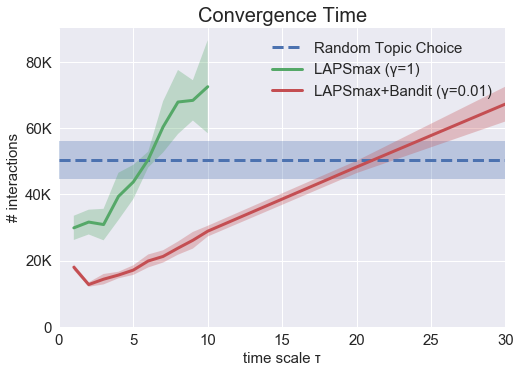

In [12]:
g1 = plot_2_bis('conv_time')
g1.legendoptions['labels'] = ['Random Topic Choice','LAPSmax (γ=1)','LAPSmax+Bandit (γ=0.01)']
g1.Yoptions[0]['linestyle'] = '--'
g1.title = 'Convergence Time'
g1.xmin = 0
g1.xmax = timesc_values[-1]
g1.xlabel = 'time scale τ'
g1.ylabel = '# interactions'
g1.yticker = True
g1.show()
None

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


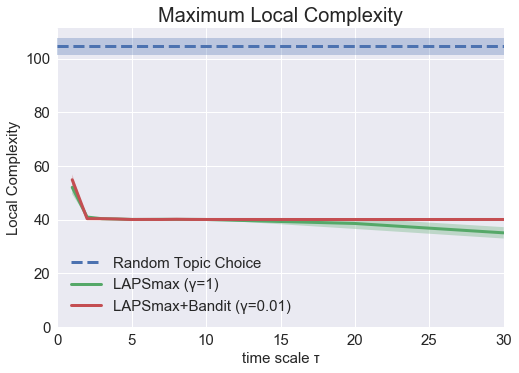

In [13]:
g1 = plot_2_bis('max_mem')
g1.legendoptions['labels'] = ['Random Topic Choice','LAPSmax (γ=1)','LAPSmax+Bandit (γ=0.01)']
g1.Yoptions[0]['linestyle'] = '--'
g1.title = 'Maximum Local Complexity'
g1.xmin = 0
g1.xmax = timesc_values[-1]
g1.xlabel = 'time scale τ'
g1.ylabel = 'Local Complexity'
g1.show()
None

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


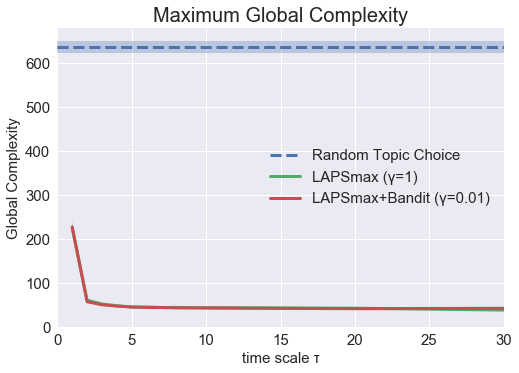

In [14]:
g1 = plot_2_bis('max_N_d')
g1.legendoptions['labels'] = ['Random Topic Choice','LAPSmax (γ=1)','LAPSmax+Bandit (γ=0.01)']
g1.Yoptions[0]['linestyle'] = '--'
g1.title = 'Maximum Global Complexity'
g1.xmin = 0
g1.xmax = timesc_values[-1]
g1.xlabel = 'time scale τ'
g1.ylabel = 'Global Complexity'
g1.show()
None

In [15]:
def plot_3(N=40,M=40,W=40,t=None,Tmax=None,nbiter=8,gamma=0.01,an_f='srtheo'):
    if t is None:
        cfg_l = [xp_cfg(N,M,W)]+[xp_cfg(N,M,W,accpol=True,time_scale=tt,gamma=gamma) for tt in timesc_values]
    else:
        cfg_l = [xp_cfg(N,M,W)]+[xp_cfg(N,M,W,accpol=True,time_scale=tt,gamma=gamma)for tt in t]
    gr = get_merged_graph(cfg=cfg_l[0],an_f=an_f,nbiter=nbiter)
    for cfg in cfg_l[1:]:
        gr.add_graph(get_merged_graph(cfg=cfg,an_f=an_f,nbiter=nbiter))
    if t is None:
        gr.legendoptions['labels'] = ['Random Topic Choice']+['τ='+str(tt) for tt in timesc_values]
    else:
        gr.legendoptions['labels'] = ['Random Topic Choice']+['τ='+str(tt) for tt in t]
    return gr

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


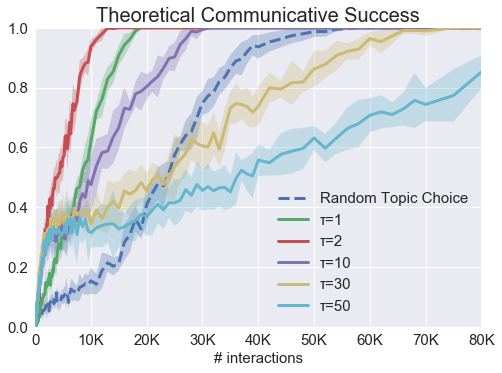

In [16]:
g3 = plot_3(t=tsc_2)
g3.Yoptions[0]['linestyle'] = '--'
g3.title = 'Theoretical Communicative Success'
g3.xmin = 0
g3.xmax = 80000
g3.xlabel = '# interactions'
g3.xticker = True
g3.show()
None

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


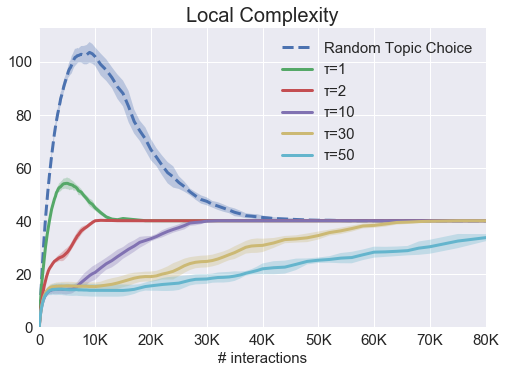

In [17]:
g3 = plot_3(t=tsc_2,an_f='Nlink')
g3.Yoptions[0]['linestyle'] = '--'
g3.title = 'Local Complexity'
g3.xmin = 0
g3.xmax = 80000
g3.xlabel = '# interactions'
g3.xticker = True
g3.show()
None

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


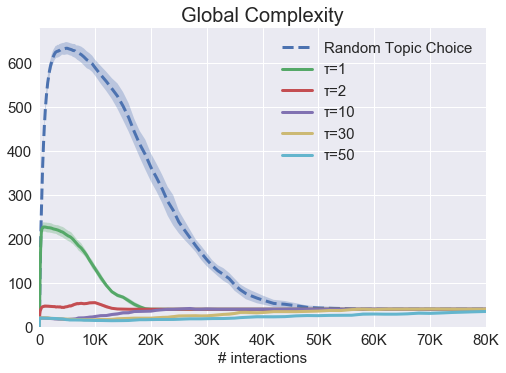

In [18]:
g3 = plot_3(t=tsc_2,an_f='N_d')
g3.Yoptions[0]['linestyle'] = '--'
g3.title = 'Global Complexity'
g3.xmin = 0
g3.xmax = 80000
g3.xlabel = '# interactions'
g3.xticker = True
g3.show()


None